# Import the required packages

In [1]:
from collections import OrderedDict
from glob import glob
from datetime import datetime, timedelta
import string
import os
import itertools
import random

import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import warnings
from matplotlib import ticker
from sklearn.preprocessing import MinMaxScaler

warnings.filterwarnings('ignore')

%matplotlib inline

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'png')

plot_font_dict = {'fontname':'Arial'}

# Error metric is normalized root mean square error (NRMSE)
def NRMSE(yhat, y):
    num = np.sqrt(np.mean((yhat.flatten() - y.flatten())**2))
    den = max(y) - min(y)
    return num / den

def normalize_data(data, max_bound=1, min_bound=-1):
    return (max_bound - min_bound) * (data - min(data)) / (max(data) - min(data)) + min_bound

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

# View the raw data

Text(0.5, 0, 'Time (h)')

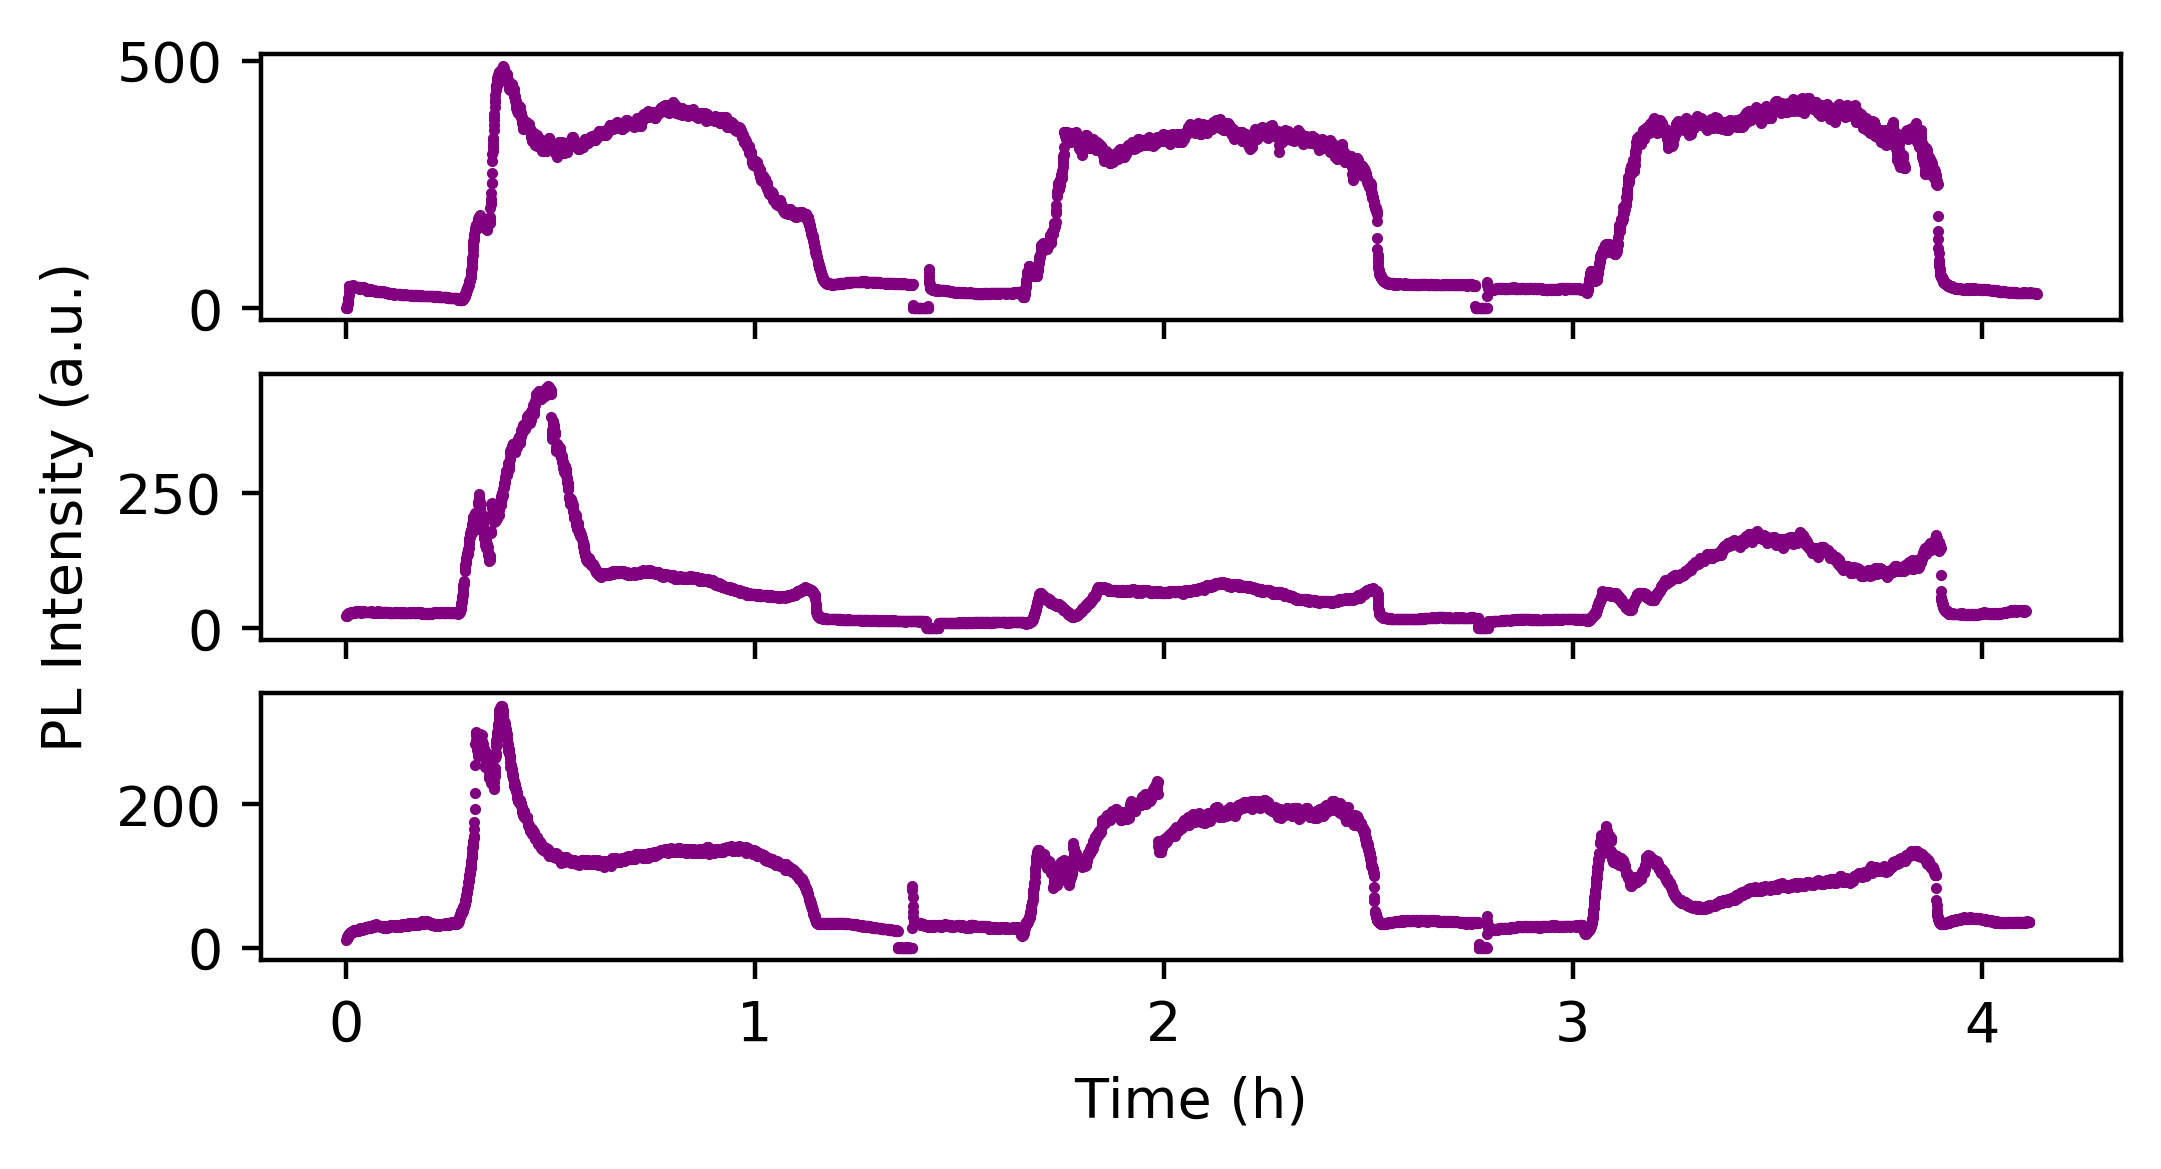

In [3]:
fig, axarr = plt.subplots(3, 1, sharex=True)
axes = axarr.flatten()
fig.dpi = 400
fig.set_size_inches((6, 3))

data_dir = '/.../' # SET FILE PATH HERE
filenum_2_df = {}

# This loop reads the data and plots it simultaneously
for file_num, rh_fpath in enumerate(sorted(glob(data_dir + '*.txt'))):
    rh_df = pd.read_csv(rh_fpath, sep='\t', header=0, infer_datetime_format=True)
    rh_df['date_time'] = pd.to_datetime(rh_df['date_time'])
    rh_df = rh_df.set_index('date_time')
    rh_df['duration_s'] = pd.to_timedelta(rh_df.index - rh_df.index[0]).astype('timedelta64[s]')
    rh_df['duration_h'] = rh_df['duration_s'] / 3600
    
    axes[file_num].scatter(rh_df.duration_h, rh_df.photoluminescence, color='purple', s=1)   
    
    if file_num == 1:
        axes[file_num].set_ylabel('PL Intensity (a.u.)')

axes[file_num].set_xlabel('Time (h)')

# Data pre-processing

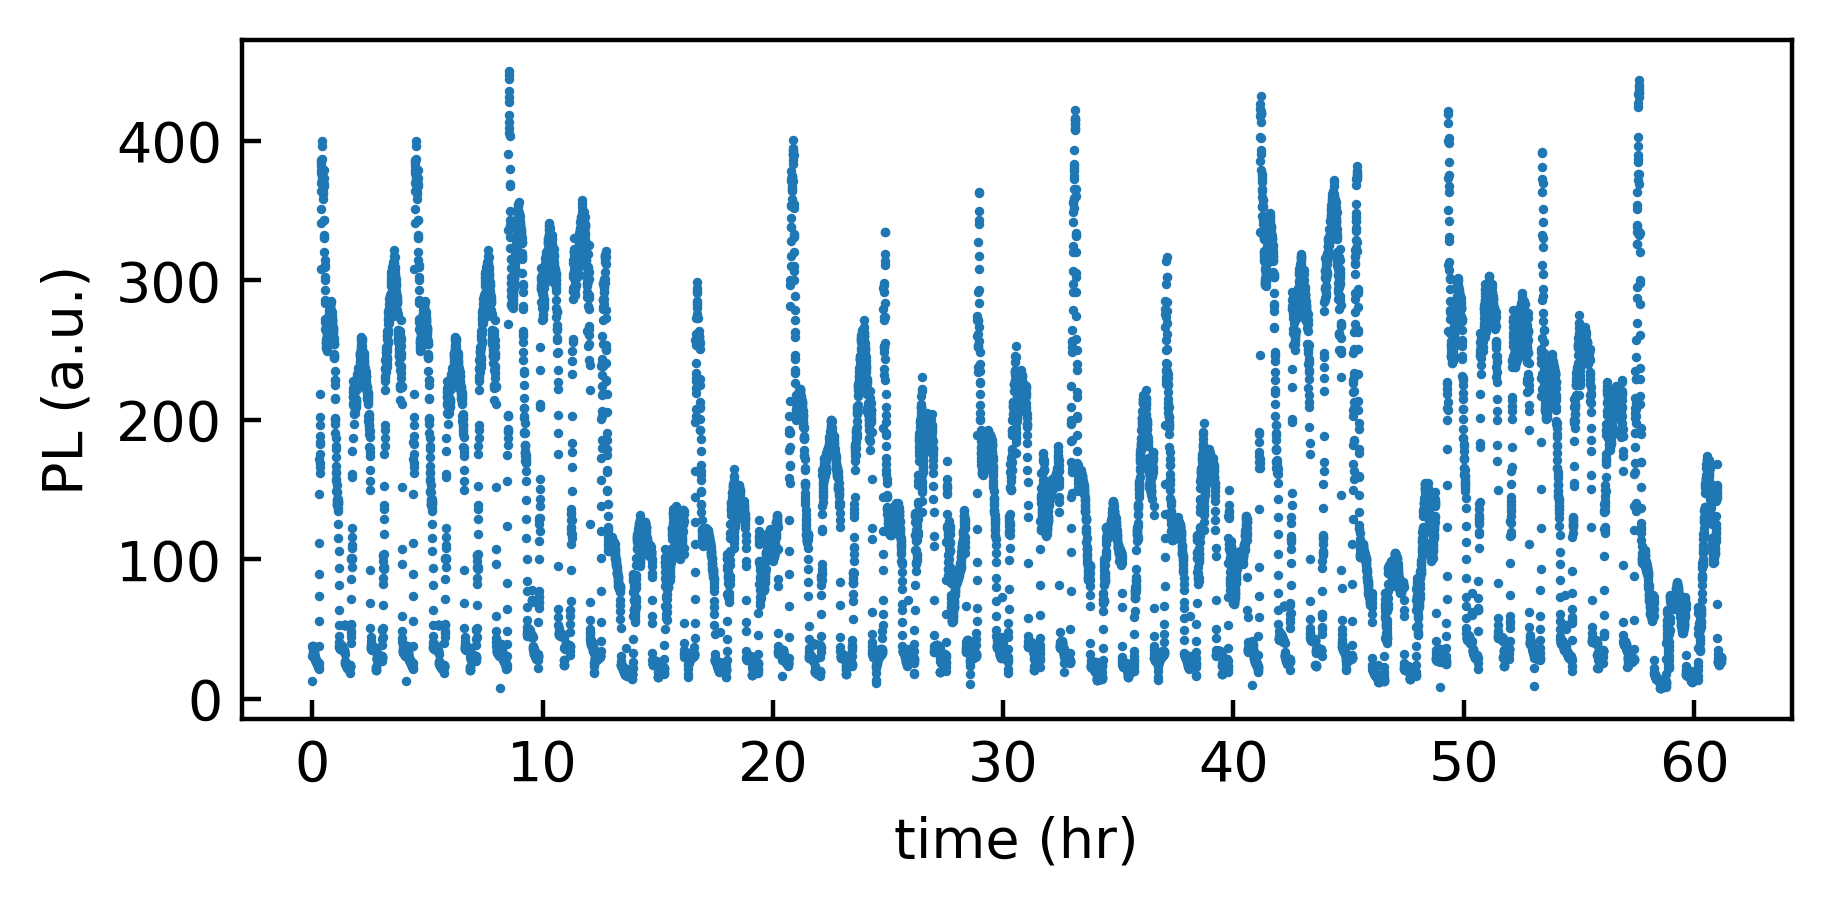

In [4]:
DURATION = 14684.9976
RESAMPLE_FREQ = '15S'
INTERP_STEP = 0.2

# Function to resample the data using a linear interpolation method
def preprocess_rh_pl(data_dir, clean_threshold=0, duration=DURATION, resample_freq=RESAMPLE_FREQ, interp_step=INTERP_STEP):
    
    filenum_2_df = {}
    for file_num, rh_fpath in enumerate(sorted(glob(data_dir + '*.txt'))):
        
        # load data
        rh_df = pd.read_csv(rh_fpath, sep='\t', header=0, infer_datetime_format=True)
        rh_df['date_time'] = pd.to_datetime(rh_df['date_time'])
        rh_df = rh_df.set_index('date_time')
        rh_df['duration_s'] = pd.to_timedelta(rh_df.index - rh_df.index[0]).astype('timedelta64[s]')
        rh_df['duration_h'] = rh_df['duration_s'] / 3600

        # Remove gaps in data
        cleaned_rh_df = rh_df[rh_df.photoluminescence > clean_threshold]
        
        # Resample
        resamp_norm_cleaned_rh_df = cleaned_rh_df
        resamp_norm_cleaned_rh_df = resamp_norm_cleaned_rh_df.resample(RESAMPLE_FREQ).bfill() 
        resamp_norm_cleaned_rh_df['duration_s'] = pd.to_timedelta(resamp_norm_cleaned_rh_df.index - resamp_norm_cleaned_rh_df.index[0]).astype('timedelta64[s]')
        resamp_norm_cleaned_rh_df['duration_h'] = resamp_norm_cleaned_rh_df['duration_s'] / 3600

        # Cut to equal duration
        cut_resamp_norm_cleaned_rh_df = resamp_norm_cleaned_rh_df[resamp_norm_cleaned_rh_df.duration_s < DURATION]
        
        final_rh_df = cut_resamp_norm_cleaned_rh_df
        final_rh_df['rh_pl_round'] = 'pl_%s' % file_num

        try:
            final_rh_df.drop(['id', 'pd_power', 'duration_s', 'temperature'], axis=1, inplace=True)
        except KeyError:
            final_rh_df.drop(['id', 'duration_s', 'temperature'], axis=1, inplace=True)

        filenum_2_df[file_num] = final_rh_df

    combined_rh_df = None
    for file_num, rh_df in filenum_2_df.items():
        if file_num == 0:
            combined_rh_df = rh_df
        else:
            combined_rh_df = pd.concat([combined_rh_df, rh_df])

    pl_scaler = MinMaxScaler(feature_range=(-1, 1))
    rh_scaler = MinMaxScaler(feature_range=(-1, 1))
    combined_rh_df[['photoluminescence']] = pl_scaler.fit_transform(combined_rh_df[['photoluminescence']])
    combined_rh_df[['humidity']] = rh_scaler.fit_transform(combined_rh_df[['humidity']])

    # Stack
    rh_dfs = [rh_df for _, rh_df in combined_rh_df.groupby('rh_pl_round')]
    aug_rh_pl_df = rh_dfs[0].copy()
    aug_rh_pl_df.drop(['rh_pl_round', 'duration_h'], axis=1, inplace=True)
    aug_rh_pl_df = aug_rh_pl_df.values

    new_df = rh_dfs[0].copy() # solves a weird pass by reference bug
    new_df.drop(['rh_pl_round', 'duration_h'], axis=1, inplace=True)

    new_pl_vectors = []
    new_pl_vectors_lists = []
    for pair_num, (rh_df_1, rh_df_2) in enumerate(list(itertools.combinations(rh_dfs, 2))):
        pl_1 = rh_df_1.photoluminescence.values
        pl_2 = rh_df_2.photoluminescence.values

        for weight_num, weight in enumerate(np.arange(0, 1 + interp_step, interp_step)):
            pl_vec = weight * (pl_1 - pl_2) + pl_2
            pl_vec_list = list(np.round(pl_vec, 4))
            
            if pl_vec_list in new_pl_vectors_lists:
                continue
            else:
                new_pl_vectors.append(pl_vec)
                new_pl_vectors_lists.append(pl_vec_list)

    random.seed(1119)
    random.shuffle(new_pl_vectors)
    for pl_vec_num, pl_vec in enumerate(new_pl_vectors):

        new_df['photoluminescence'] = pl_vec
        if pl_vec_num == 0:
            aug_rh_pl_df = new_df.values
        else:
            aug_rh_pl_df = np.concatenate([aug_rh_pl_df, new_df.values])

    return aug_rh_pl_df, pl_scaler, rh_scaler

# Use above function on the data
DATA_DIR = 'Cs-mixed-data/'
processed_pl, pl_scaler, rh_scaler = preprocess_rh_pl(DATA_DIR, clean_threshold=5)
   
# Plot the results
fig = plt.figure()
fig.dpi = 400
fig.set_size_inches((5, 2.25))

inv_pl = pl_scaler.inverse_transform(processed_pl[:, 1].reshape(-1, 1))
plt.scatter(np.arange(0, len(inv_pl) * 15, 15) / 3600, inv_pl, s=0.5)
plt.xlabel('time (hr)')
plt.ylabel('PL (a.u.)')
plt.tick_params(axis='both', which='both', direction='in')

Text(0.5, 0, 'Time (h)')

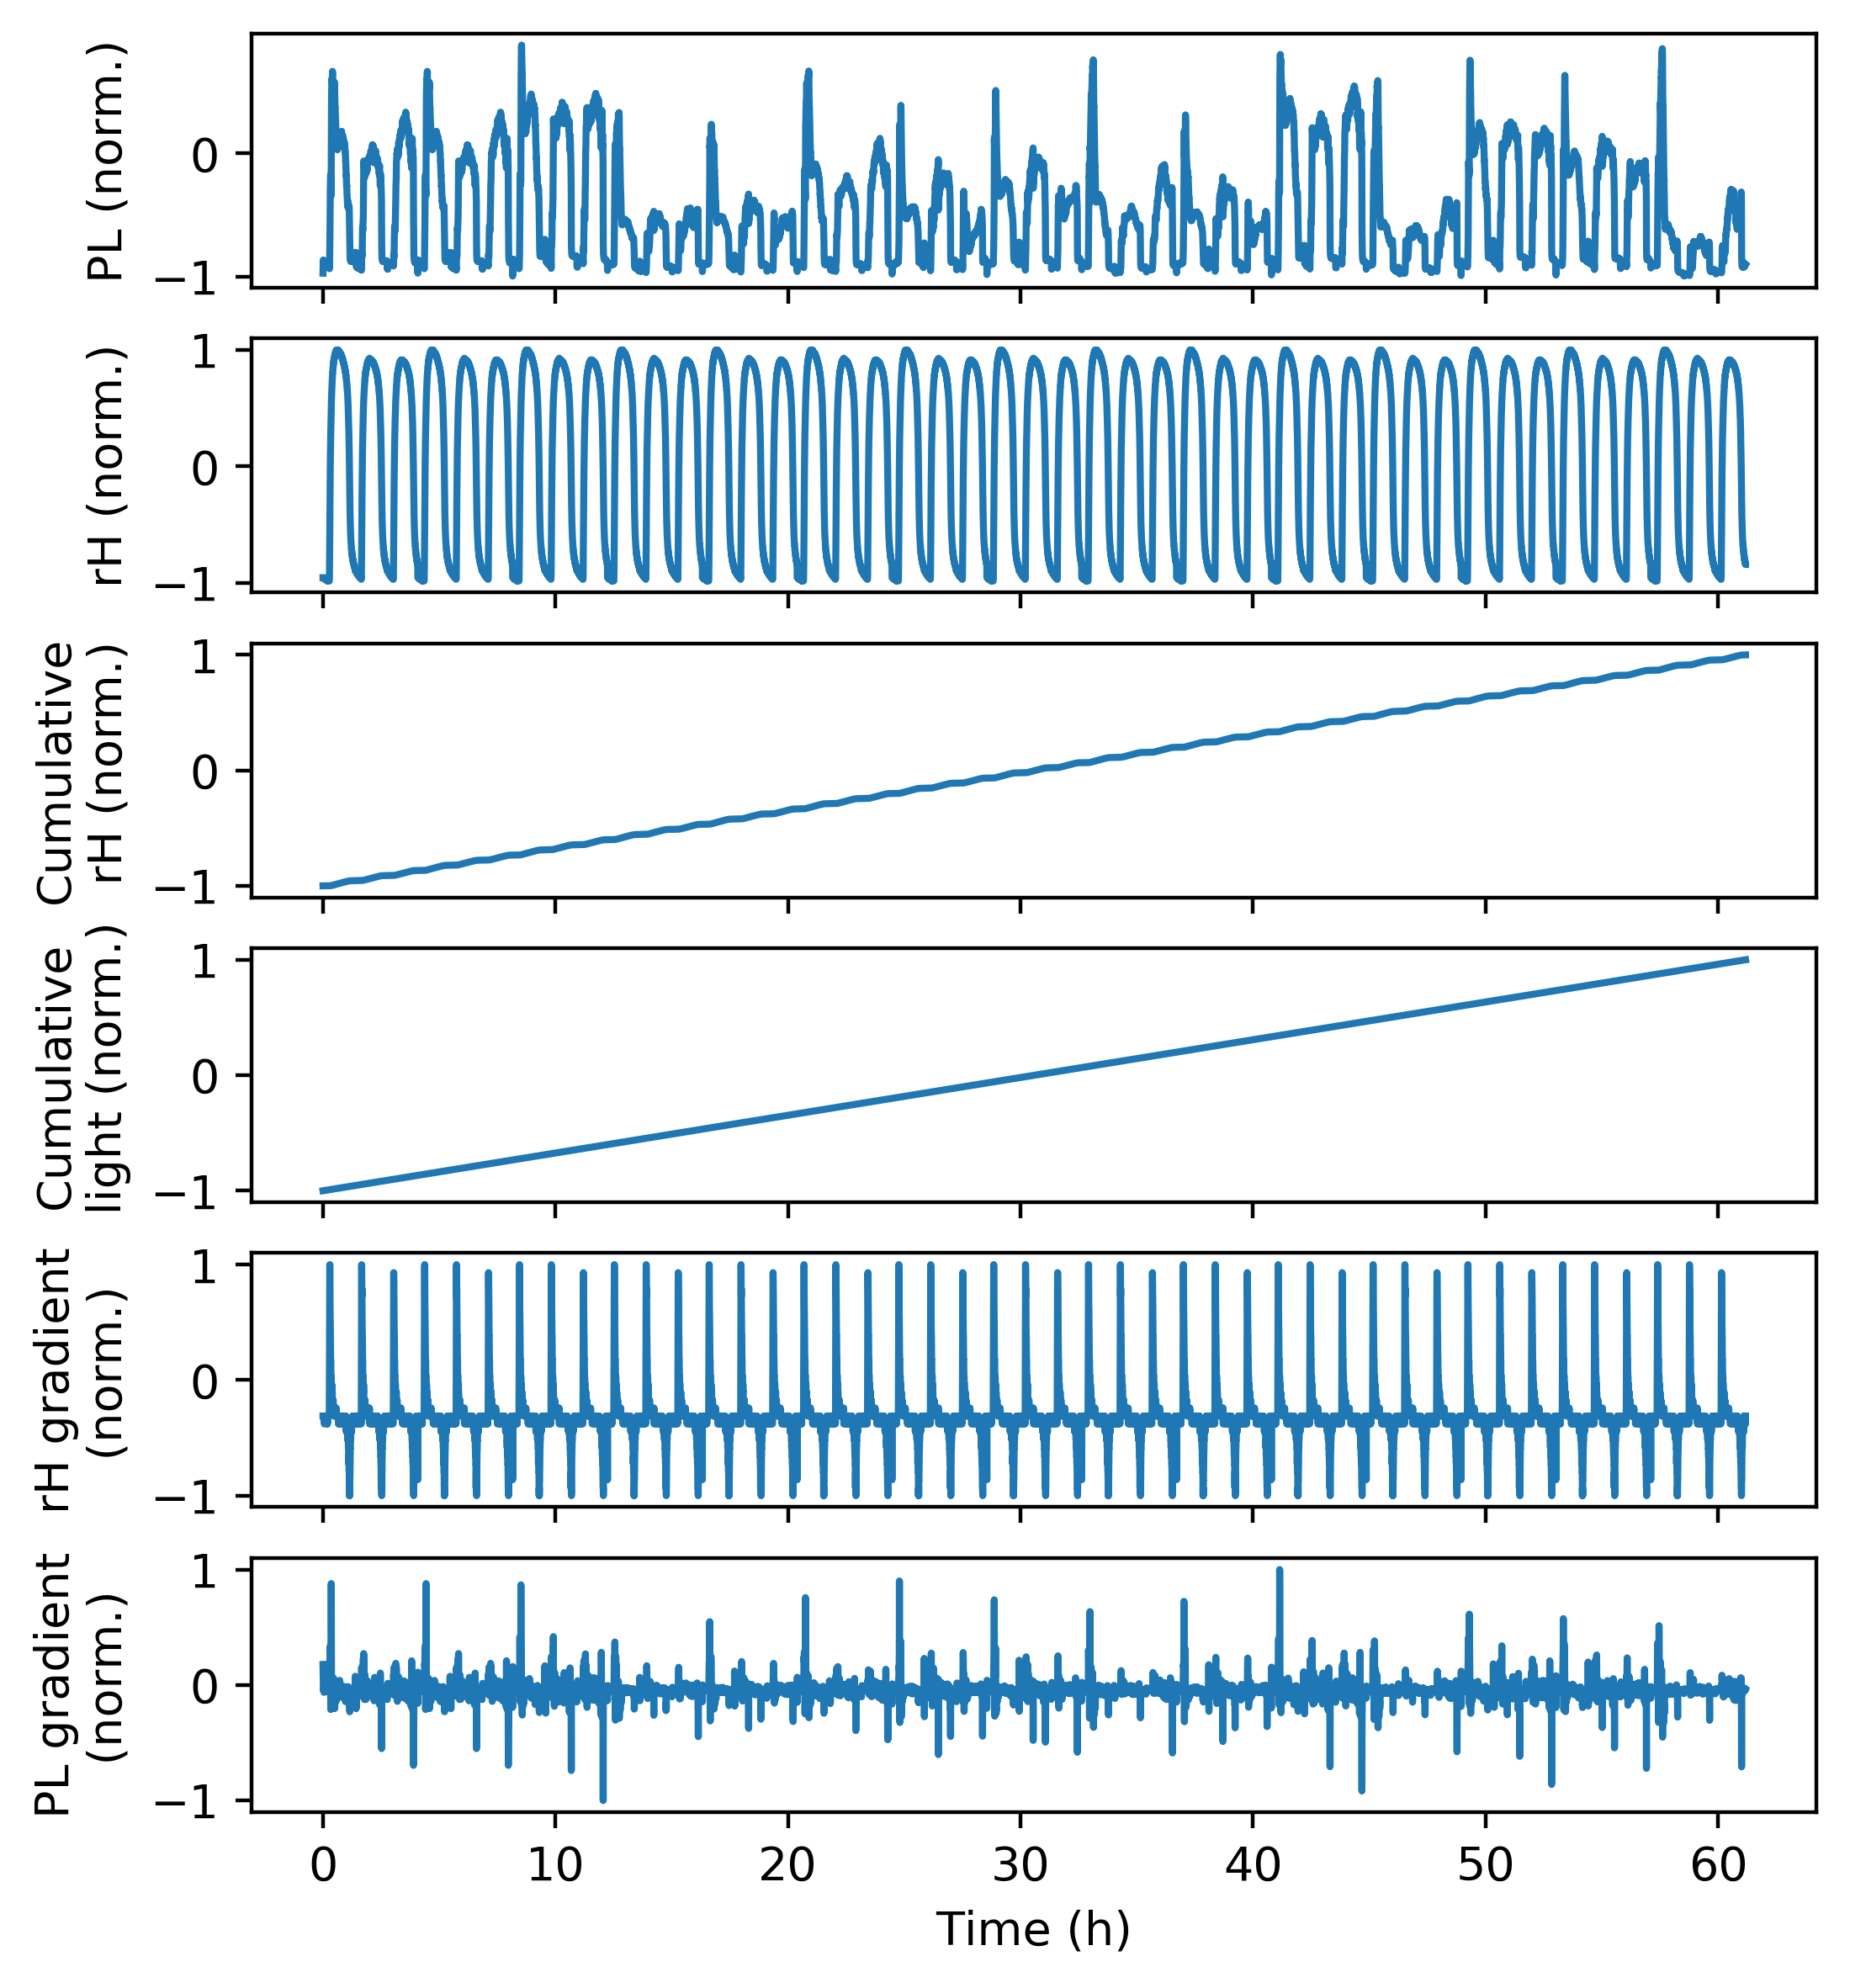

In [7]:
# Generate and visualize additional features for model training: 
# cumulative rH, cumulative light intensity, rH gradient, intensity gradient

fig, axarr = plt.subplots(6, 1, sharex=True)
axes = axarr.flatten()
fig.dpi = 400
fig.set_size_inches((6, 7))

times = np.arange(0, len(inv_pl) * 15, 15) / 3600

ax = axes[0]
ax.plot(times, processed_pl[:, 1])
ax.set_ylabel('PL (norm.)')

ax = axes[1]
ax.plot(times, processed_pl[:, 0])
ax.set_ylabel('rH (norm.)')

ax = axes[2]
moisture_cmlsum = normalize_data(np.cumsum(processed_pl[:, 0] + 1))
ax.plot(times, moisture_cmlsum)
ax.set_ylabel('Cumulative\n rH (norm.)')

ax = axes[3]
intensity_cmlsum = normalize_data(np.cumsum(np.ones(len(moisture_cmlsum))))
ax.plot(times, intensity_cmlsum)
ax.set_ylabel('Cumulative\n light (norm.)')

ax = axes[4]
rh_diff = np.gradient(processed_pl[:, 0])
rh_diff = normalize_data(rh_diff)
ax.plot(times, rh_diff)
ax.set_ylabel('rH gradient\n (norm.)')

ax = axes[5]
pl_diff = np.gradient(processed_pl[:, 1])
pl_diff = normalize_data(pl_diff)
ax.plot(times, pl_diff)
ax.set_ylabel('PL gradient\n (norm.)')

ax.set_xlabel('Time (h)')

In [9]:
# Add the additional features to the processed PL data file
# We now have an augmented data set of 14685 points with 6 features
moisture_cmlsum = moisture_cmlsum.reshape(-1, 1)
intensity_cmlsum = intensity_cmlsum.reshape(-1, 1)
rh_diff = rh_diff.reshape(-1, 1)
pl_diff = pl_diff.reshape(-1, 1)
processed_pl = np.concatenate([processed_pl, moisture_cmlsum, intensity_cmlsum, rh_diff, pl_diff], axis=1)

processed_pl.shape

(14685, 6)

# Import the Echo State Network code (from github)

In [10]:
# Using pyESN implementation of the ESN algorithm. Download from https://github.com/cknd/pyESN
from pyESN import ESN

# Train the ESN and visualize the results

Points in training set:  480
Points in testing set:  2936
NRMSE (%):  [152.98240244]
Points in training set:  1200
Points in testing set:  2936
NRMSE (%):  [24.50855077]
Points in training set:  2400
Points in testing set:  2936
NRMSE (%):  [20.67737341]
Points in training set:  4800
Points in testing set:  2936
NRMSE (%):  [14.25323463]


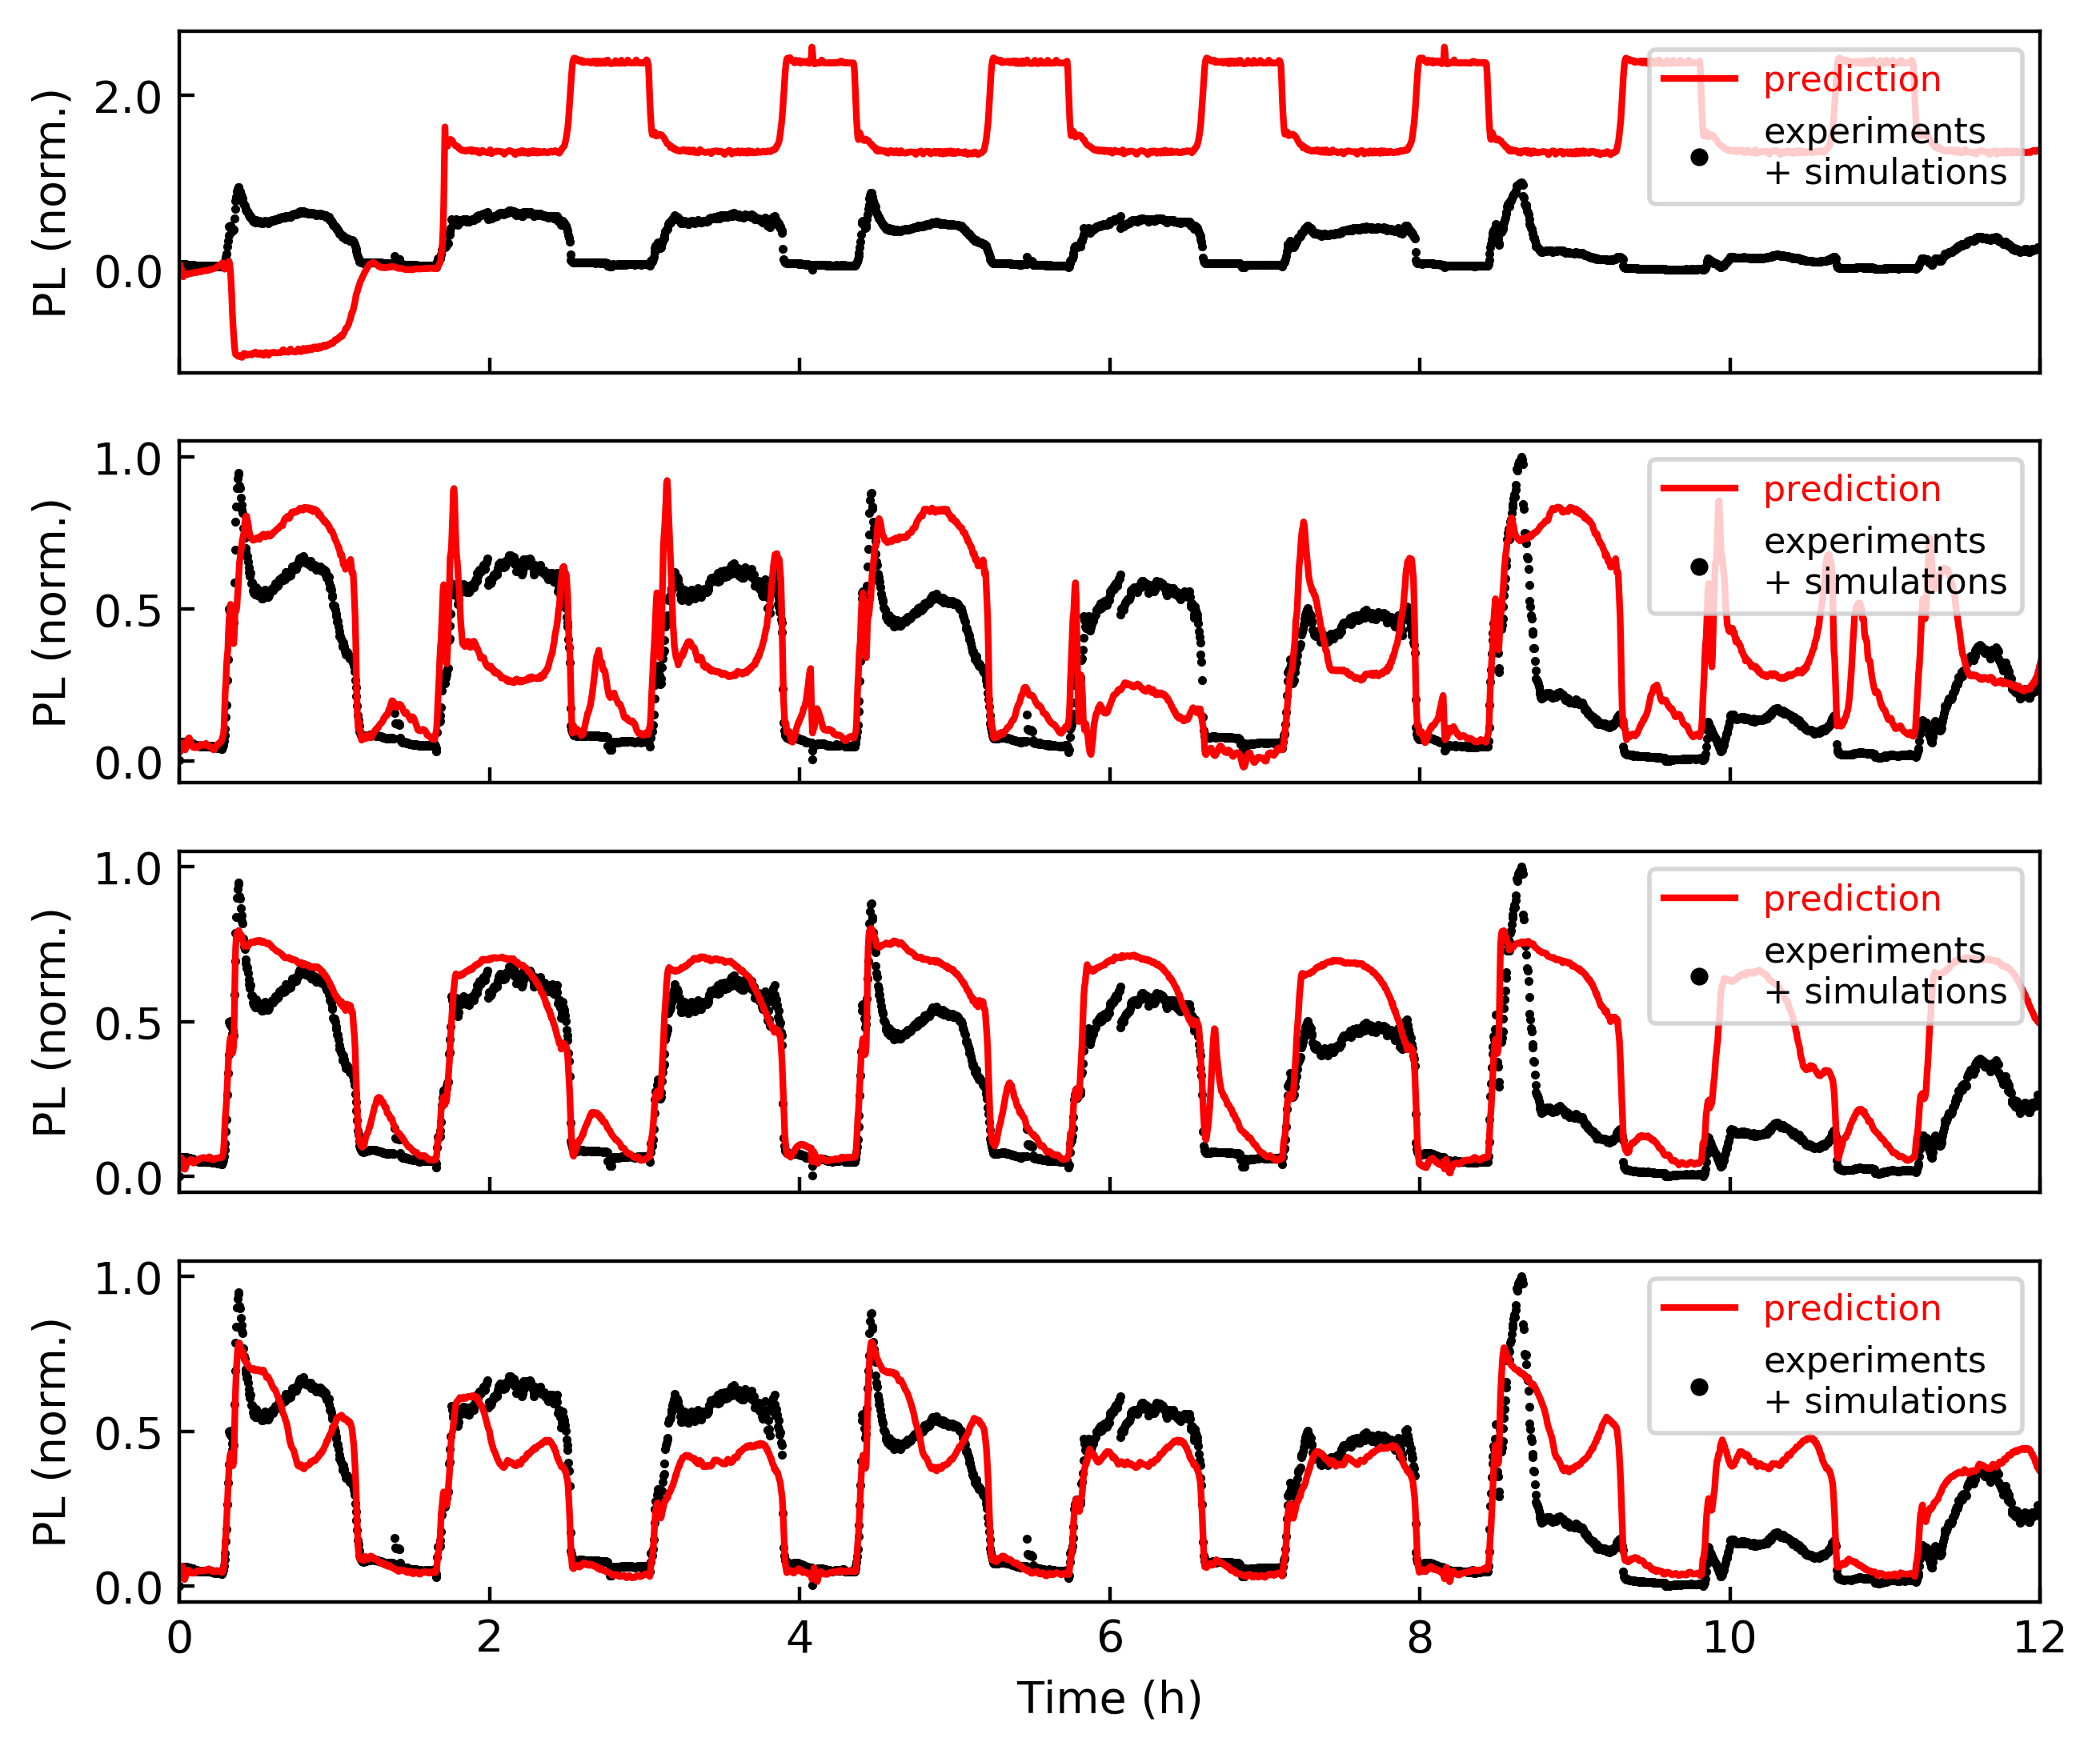

In [11]:
scaled = processed_pl
X = scaled[:, [0, 4]]
y = scaled[:, 1].reshape(-1, 1)

# Train the model four times, with training lengths of 2, 5, 10, and 20 hours
train_sizes = [2, 5, 10, 20]
testStart = int(len(X)*0.8)

fig, axarr = plt.subplots(len(train_sizes), 1, sharex='col')
fig.dpi = 400
fig.set_size_inches((7.5, 6.5))
axes = axarr.flatten()

for train_size_num, train_size in enumerate(train_sizes):

    train_size = 48.95-train_size
    trainStart = int((train_size*3600)/15)
    testX = X[testStart:len(X)-1, :]
    testY = y[testStart:len(y)-1, :]
    trainX = X[trainStart:testStart, :]
    trainY = y[trainStart:testStart, :]
    
    print('Points in training set: ', len(trainY))
    
    esn = ESN(n_inputs = trainX.shape[1], 
        n_outputs = trainY.shape[1], 
        n_reservoir = 150, 
        spectral_radius = 1.25,
        sparsity=0.1,
        noise=0.005,
        random_state=42)

    pred_training = esn.fit(trainX, trainY)
    prediction = esn.predict(testX)

    pred_pl = pl_scaler.inverse_transform(prediction)
    test_pl = pl_scaler.inverse_transform(testY.reshape(-1, 1))
    full_pl = pl_scaler.inverse_transform(y.reshape(-1,1))
    print('Points in testing set: ', len(test_pl))

    comp_color = "#7536D2"
    print('NRMSE (%): ', NRMSE(pred_pl, test_pl) * 100)

    pred_pl = (pred_pl - min(test_pl)) / (max(test_pl) - min(test_pl))
    test_pl = (test_pl - min(test_pl)) / (max(test_pl) - min(test_pl))
    full_pl = (full_pl - min(full_pl)) / (max(full_pl) - min(full_pl))

    axes[train_size_num].scatter(np.arange(0, len(test_pl) * 15, 15) / 3600, test_pl, color='k', s=1, label='experiments\n+ simulations')
    axes[train_size_num].plot(np.arange(0, len(test_pl) * 15, 15)/ 3600, pred_pl, ls='-', color='r', label='prediction')
    
    axes[train_size_num].set_ylabel('PL (norm.)')
    
    axes[train_size_num].tick_params(axis='both', which='both', direction='in')
    axes[train_size_num].set_xlim(0, 12)
    if train_size < 45:
        axes[train_size_num].set_yticks([0, 0.5, 1])
        axes[train_size_num].set_yticklabels(["0.0", "0.5", "1.0"])
    if train_size_num == 0:
        axes[train_size_num].set_yticks([0, 2])
        axes[train_size_num].set_yticklabels(["0.0", "2.0"]) 
        
    if train_size_num == len(train_sizes)-1:
        axes[train_size_num].set_xlabel('Time (h)')
        
    axes[train_size_num].legend(fontsize=8, loc='upper right', frameon=True, markerscale=3)
    handles, labels = axes[train_size_num].get_legend_handles_labels()

    leg = axes[train_size_num].legend(handles, labels, fontsize=8, loc='upper right', frameon=True, shadow=False, framealpha=0.8, markerscale=3)

    for handle, text in zip(leg.legendHandles, leg.get_texts()):
        try:
            text.set_color(handle.get_facecolor()[0])
        except AttributeError:
            break
                
    for line,text in zip(leg.get_lines(), leg.get_texts()):
        text.set_color(line.get_color())

# Tune ESN hyperparameters using a grid-search approach

Spectral Radius =  0.01 , Noise =  0.001 , NRMSE =  15.330917539571898
Spectral Radius =  0.01 , Noise =  0.005 , NRMSE =  15.11571163022193
Spectral Radius =  0.01 , Noise =  0.01 , NRMSE =  15.166565171916577
Spectral Radius =  0.01 , Noise =  0.025 , NRMSE =  16.448634340278357
Spectral Radius =  0.01 , Noise =  0.05 , NRMSE =  18.863498420219578
Spectral Radius =  0.01 , Noise =  0.1 , NRMSE =  20.074064519829847
Spectral Radius =  0.05 , Noise =  0.001 , NRMSE =  15.122582868065198
Spectral Radius =  0.05 , Noise =  0.005 , NRMSE =  15.105485851852224
Spectral Radius =  0.05 , Noise =  0.01 , NRMSE =  15.039966134121642
Spectral Radius =  0.05 , Noise =  0.025 , NRMSE =  16.32266381867159
Spectral Radius =  0.05 , Noise =  0.05 , NRMSE =  18.8687000881477
Spectral Radius =  0.05 , Noise =  0.1 , NRMSE =  20.09741030937721
Spectral Radius =  0.1 , Noise =  0.001 , NRMSE =  14.839640996919535
Spectral Radius =  0.1 , Noise =  0.005 , NRMSE =  15.068335206514153
Spectral Radius =  0.

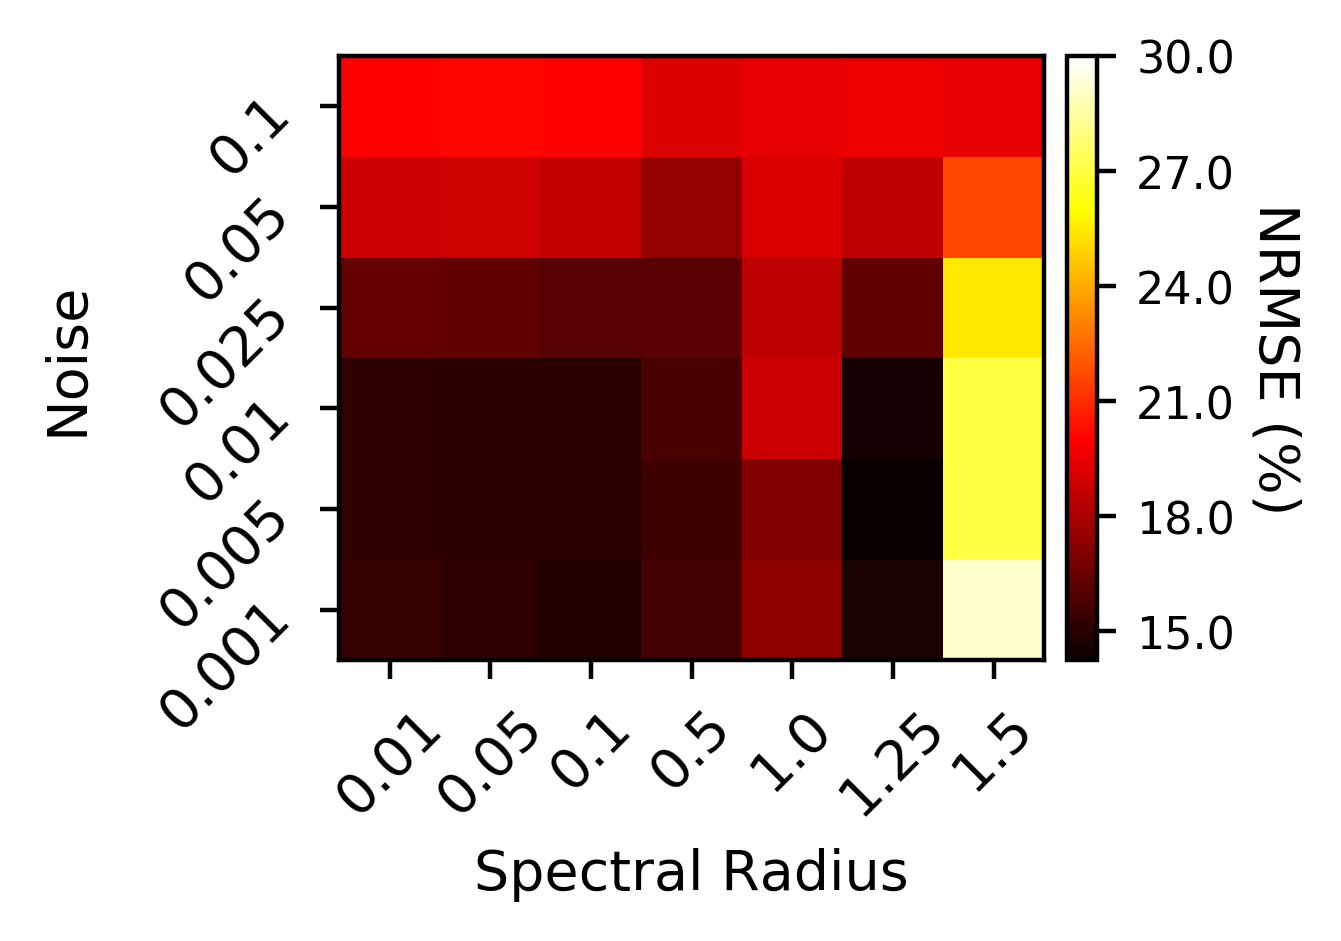

In [12]:
n_reservoir= 200
sparsity   = 0.1
rand_seed  = 42

# Traverse a set of seven values for ESN spectral radius and six values for ESN noise
radius_set = [0.01, 0.05, 0.1, 0.5, 1.0, 1.25, 1.5]
noise_set = [0.001, 0.005, 0.01, 0.025, 0.05, 0.1]
    
radius_set_size  = len(radius_set)
noise_set_size = len(noise_set)

loss = np.zeros([radius_set_size, noise_set_size])

train_size = 20

train_size = 48.95-train_size
testStart = int(len(X)*0.8)
trainStart = int((train_size*3600)/15)
testX = X[testStart:len(X)-1, :]
testY = y[testStart:len(y)-1, :]
trainX = X[trainStart:testStart, :]
trainY = y[trainStart:testStart, :]

# Loop through all combinations of spectral radius and noise
for l in range(radius_set_size):
    rho = radius_set[l]
    
    for j in range(noise_set_size):
        noise = noise_set[j]
        
        esn = ESN(n_inputs = trainX.shape[1], 
                  n_outputs = trainY.shape[1], 
                  n_reservoir = 150, 
                  spectral_radius = rho,
                  sparsity=0.1,
                  noise=noise,
                  random_state=42)


        pred_training = esn.fit(trainX, trainY) 
        prediction = esn.predict(testX)
    
        pred_pl = pl_scaler.inverse_transform(prediction)
        test_pl = pl_scaler.inverse_transform(testY.reshape(-1, 1))

        # Print NRMSE for each combination
        loss[l, j] = NRMSE(pred_pl, test_pl) * 100
        print('Spectral Radius = ', radius_set[l], ', Noise = ', noise_set[j], ', NRMSE = ', loss[l][j] )

# Visualize the results using a colormap
fig = plt.figure()
fig.dpi = 400
fig.set_size_inches((3, 2))

im = plt.imshow(loss.T, vmin=abs(loss).min(), vmax=30, origin='lower',cmap='hot')
plt.xticks(np.linspace(0,radius_set_size-1,radius_set_size), radius_set);
plt.yticks(np.linspace(0,noise_set_size-1, noise_set_size), noise_set);
plt.xlabel(r'$\rho$') 
plt.xlabel('Spectral Radius') 
plt.ylabel('Noise', labelpad=10)
plt.xticks(rotation=45)
plt.yticks(rotation=45)

ax = plt.gca()

cb = plt.colorbar(im, pad=0.025); 
cb.ax.tick_params(labelsize=8)
cb.set_label('NRMSE (%)', rotation=270, labelpad=12) #, fontsize=8)

tick_locator = ticker.MaxNLocator(nbins=6)
cb.locator = tick_locator
cb.update_ticks()
cb.ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.1f'))


Prediction 1 NRMSE (%):  [14.25323463]
Prediction 2 NRMSE (%):  [20.06540179]
Prediction 3 NRMSE (%):  [25.50301136]


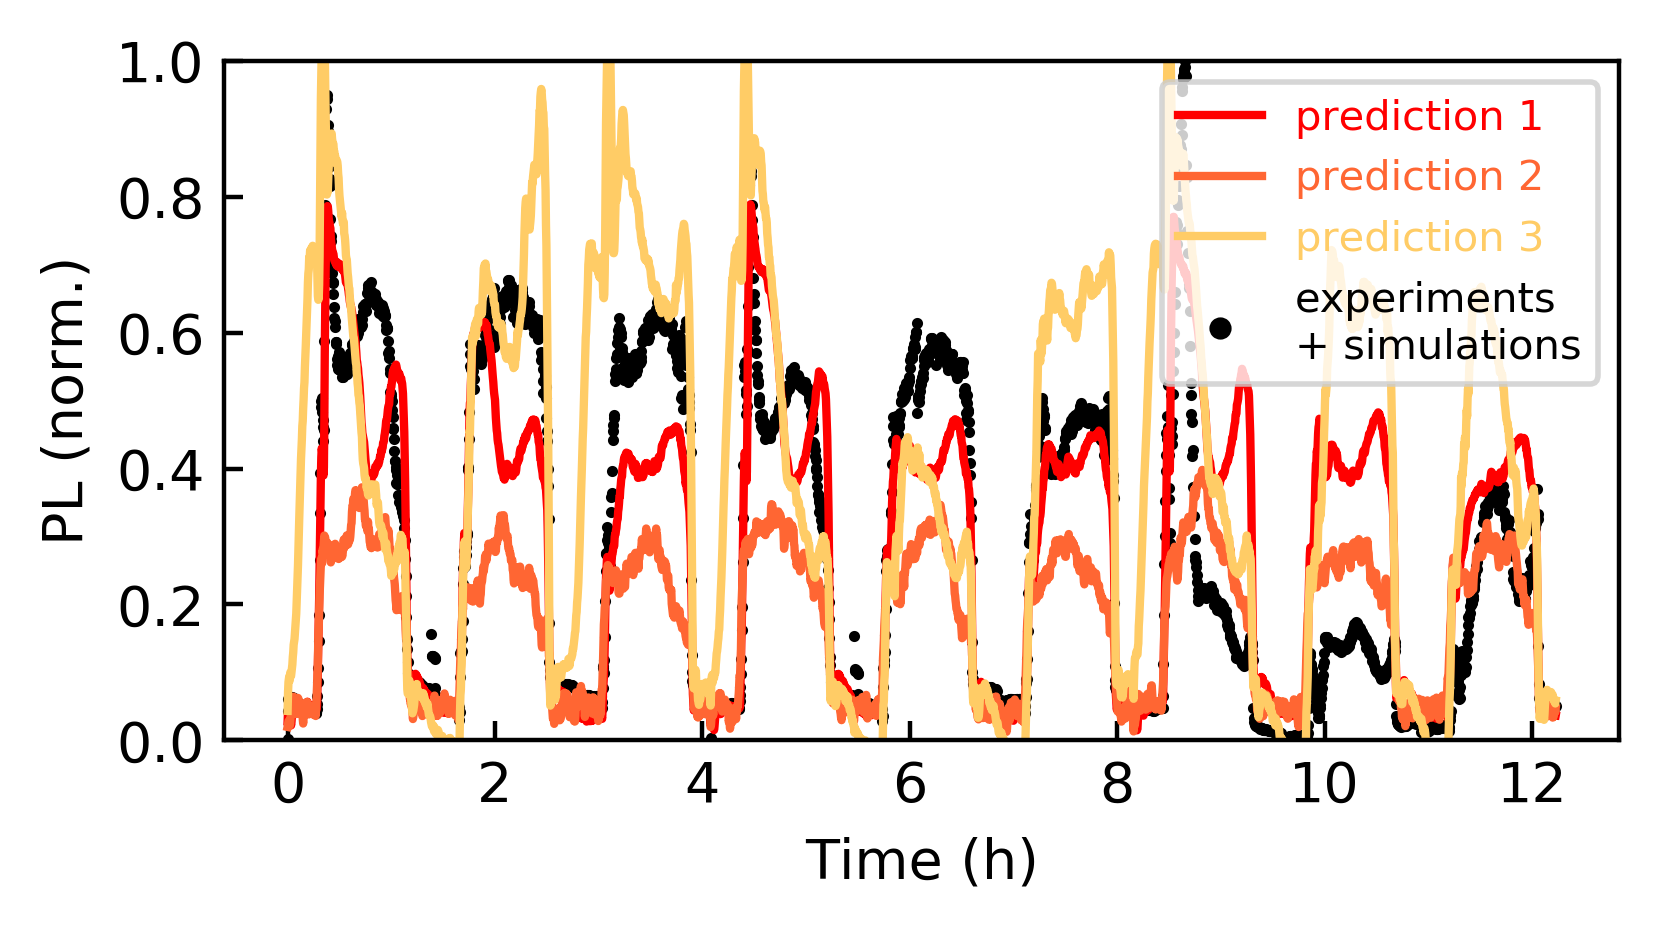

In [18]:
# Plot test results for a few representative versions of the ESN, showcasing good and bad choices for hyperparameters

scaled = processed_pl
X = scaled[:, [0, 4]]
y = scaled[:, 1].reshape(-1, 1)

train_size = 20

train_size = 48.95-train_size
trainStart = int((train_size*3600)/15)
testX = X[testStart:len(X)-1, :]
testY = y[testStart:len(y)-1, :]
trainX = X[trainStart:testStart, :]
trainY = y[trainStart:testStart, :]

radius_set = [1.25, 0.1, 1.5] # Set of spectral radii
noise_set = [0.005, 0.1, 0.025] # Set of noise values
    
radius_set_size  = len(radius_set)
noise_set_size = len(noise_set)

fig = plt.figure()
fig.dpi = 400
fig.set_size_inches((4.5, 2.25))

for l in range(radius_set_size):
    rho = radius_set[l]
    noise = noise_set[l]
        
    esn = ESN(n_inputs = trainX.shape[1], 
        n_outputs = trainY.shape[1], 
        n_reservoir = 150, 
        spectral_radius = rho,
        sparsity=0.1,
        noise=noise,
        random_state=42)


    pred_training = esn.fit(trainX, trainY) 
    prediction = esn.predict(testX)
    
    pred_pl = pl_scaler.inverse_transform(prediction)
    test_pl = pl_scaler.inverse_transform(testY.reshape(-1, 1))

    print('Prediction', l+1 , 'NRMSE (%): ', NRMSE(pred_pl, test_pl) * 100)

    pred_pl = (pred_pl - min(test_pl)) / (max(test_pl) - min(test_pl))
    test_pl = (test_pl - min(test_pl)) / (max(test_pl) - min(test_pl))
    
    # Plot prediction 1 (best case)
    if l == 0:
        plt.scatter(np.arange(0, len(test_pl) * 15, 15) / 3600, test_pl, color='k', s=1, label='experiments\n+ simulations')
        plt.plot(np.arange(0, len(test_pl) * 15, 15) / 3600, pred_pl, ls='-', color='r', label='prediction 1')
    
    # Plot prediction 2 (middle case)
    if l == 1:
        plt.plot(np.arange(0, len(test_pl) * 15, 15) / 3600, pred_pl, ls='-', color='#FF6633', label='prediction 2')
    
    # Plot prediction 3 (worst case)
    if l == 2:
        plt.plot(np.arange(0, len(test_pl) * 15, 15) / 3600, pred_pl, ls='-', color='#FFCC66', label='prediction 3')

plt.xlabel('Time (h)')
plt.ylabel('PL (norm.)')
plt.ylim(0, 1)

ax = plt.gca()
ax.legend(fontsize=8, loc='upper right', frameon=False, markerscale=3)
handles, labels = ax.get_legend_handles_labels()

leg = ax.legend(handles, labels, fontsize=7.5, loc='upper right', frameon=True, framealpha=0.8, markerscale=3)

for handle, text in zip(leg.legendHandles, leg.get_texts()):
    try:
        text.set_color(handle.get_facecolor()[0])
    except AttributeError:
        break
    
for line,text in zip(leg.get_lines(), leg.get_texts()):
    text.set_color(line.get_color())

plt.tick_params(axis='both', which='both', direction='in')